In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess your data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'sorted_training/train',
    labels='inferred',
    label_mode='categorical',
    class_names=['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    image_size=(48,30),
    batch_size=32)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'sorted_training/test',
    labels='inferred',
    label_mode='categorical',
    class_names=['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    image_size=(48,30),
    batch_size=128)

# Build your model
model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')
])

# Compile your model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

# Train your model
model.fit(train_ds, epochs=3)

# Evaluate your model
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy}')

# Save the model
model.save("custom_model.h5")

Found 1110 files belonging to 9 classes.
Found 366 files belonging to 9 classes.
Epoch 1/3
35/35 [==============================] - 2s 23ms/step - loss: 1.2929 - accuracy: 0.6234
Epoch 2/3
35/35 [==============================] - 1s 23ms/step - loss: 0.3186 - accuracy: 0.9180
Epoch 3/3
3/3 [==============================] - 0s 20ms/step - loss: 0.3711 - accuracy: 0.9044
Test accuracy: 0.9043715596199036


1/1 [==============================] - 0s 22ms/step


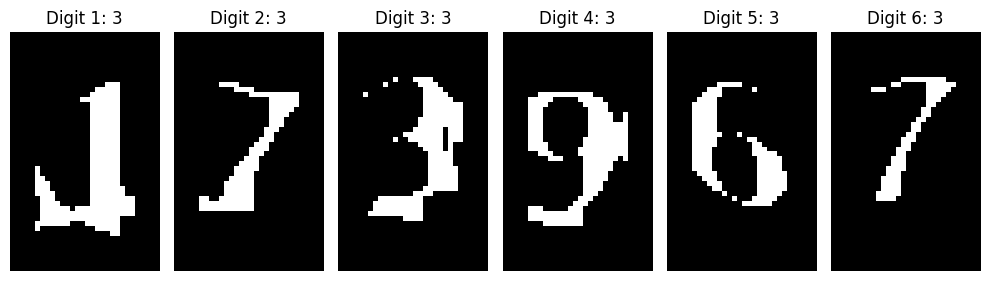

Recognized digits: 333333


In [34]:
import cv2
import numpy as np
import base64
from PIL import Image
from io import BytesIO
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

mnist_model = load_model("custom_model.h5")

def segment_img(input_img):
    # Convert the PIL Image to a NumPy array
    image_array = np.array(input_img)
    
    # Image processing
    # Convert to grayscale
    img = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)
    
    # Adaptive thresholding
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 2)

    # Otsu thresholding
    ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Otsu thresholding with Gaussian blur
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)

    dilation = cv2.dilate(th3, kernel, iterations=1)

    erosion = cv2.erode(dilation, kernel, iterations=1)

    kernel = np.ones((3,1), np.uint8)
    dilation = cv2.dilate(erosion, kernel, iterations=2)

    # Get individual letters
    x, y, w, h = 22, 10, 20, 38
    segments = []
    for i in range(6):
        # Save each character as a separate image
        digit = dilation[y:y + h, x:x + w]

        # Add a white border of 8 pixels
        digit = cv2.copyMakeBorder(digit, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        # Convert the digit to PIL Image
        digit_pil = Image.fromarray(digit)

        # Append the digit to the list of segments
        segments.append(digit_pil)

        x += w

    return segments


# Load the image file
image_file = "captcha_imgs/captcha_21.jpg"
with open(image_file, 'rb') as file:
    image_data = base64.b64encode(file.read()).decode('utf-8')

# Decode image from base64 and create an Image object
image_bytes = base64.b64decode(image_data)
image = Image.open(BytesIO(image_bytes))

# Segment the image
segmented_images = segment_img(image)

# Preprocess and display all segments using Matplotlib
preprocessed_segments = []
for i, segment in enumerate(segmented_images):
    # Preprocess the segment
    segment = np.array(segment)
    # segment = cv2.resize(segment, (28, 28))
    segment = np.invert(segment)
    segment = segment.astype('float32') / 255.0  # Normalize to [0, 1]
    segment = np.expand_dims(segment, axis=-1)  # Add channel dimension
    
    preprocessed_segments.append(segment)
    
# Predict the digits and print the images
recognized_text = ""
fig, axs = plt.subplots(1, len(preprocessed_segments), figsize=(10, 4))
for i, segment in enumerate(preprocessed_segments):
    # Reshape and resize the segment for prediction
    segment = segment.reshape(48, 30, 1)
    segment = tf.image.resize(segment, (48, 30))
    segment = np.concatenate([segment, segment, segment], axis=-1)
    
    # Predict the digit using the pre-trained Keras MNIST model
    digit = mnist_model.predict(np.array([segment]))
    
    # Append the recognized digit to the recognized text
    recognized_digit = str(np.argmax(digit))
    recognized_text += recognized_digit
    
    # Display the segment image with the recognized digit
    axs[i].imshow(segment, plt.cm.binary)
    axs[i].axis('off')
    axs[i].set_title(f"Digit {i+1}: {recognized_digit}")
plt.tight_layout()
plt.show()

print("Recognized digits:", recognized_text)

